In [3]:
import pandas as pd
import numpy as np
import networkit as nk

## Load Data

In [4]:
# Load corrected annotation table
annot_df = pd.read_parquet("../data/annotation_table_with_uniprot_corrected.parquet")
print(f"Annotation table shape: {annot_df.shape}")

Annotation table shape: (114537, 750)


In [5]:
# Load filtered ChEMBL affinity data
affinity_df = pd.read_parquet("../data/filtered_chembl_affinity.parquet")
print(f"Affinity data shape: {affinity_df.shape}")
print(f"Unique UniProt IDs in affinity data: {affinity_df['source_uniprot_id'].nunique()}")

Affinity data shape: (333611, 73)
Unique UniProt IDs in affinity data: 837


In [6]:
# Get UniProt IDs from affinity data
target_uniprots = set(affinity_df['source_uniprot_id'].dropna().unique())
print(f"Target UniProt IDs: {len(target_uniprots)}")

Target UniProt IDs: 837


## Build Bipartite Graph (UniProt - PDB mapping)
Using NetworkKit to create a bipartite graph where:
- One set of nodes: UniProt IDs (from affinity data)
- Other set of nodes: PDB chains (from annotation table)
- Edges: Exist between UniProt ID and PDB_chain if they map to each other

In [7]:
# Filter annotation table to only include UniProt IDs from affinity data
# Note: uniprot_ids_str can contain multiple comma-separated UniProt IDs
# We need to check if any of the target UniProt IDs are in the string

def contains_target_uniprot(uniprot_str):
    """Check if any target UniProt ID is in the comma-separated string"""
    if pd.isna(uniprot_str):
        return False
    uniprots = [u.strip() for u in str(uniprot_str).split(',')]
    return any(u in target_uniprots for u in uniprots)

# Filter rows where uniprot_ids_str contains at least one target UniProt
mask = annot_df['uniprot_ids_str'].apply(contains_target_uniprot)
filtered_annot = annot_df[mask].copy()
print(f"Filtered annotation rows: {len(filtered_annot)}")

Filtered annotation rows: 26425


In [8]:
# Expand the comma-separated UniProt IDs into separate rows
# Then filter to keep only target UniProt IDs

edges_list = []
for _, row in filtered_annot.iterrows():
    pdb_chain = row['pdb_chain_key']
    if pd.isna(row['uniprot_ids_str']):
        continue
    uniprots = [u.strip() for u in str(row['uniprot_ids_str']).split(',')]
    for uniprot in uniprots:
        if uniprot in target_uniprots:
            edges_list.append({'uniprot': uniprot, 'pdb_chain': pdb_chain})

edges_df = pd.DataFrame(edges_list).drop_duplicates()
print(f"Number of unique edges: {len(edges_df)}")
print(f"Unique UniProt IDs in edges: {edges_df['uniprot'].nunique()}")
print(f"Unique PDB chains in edges: {edges_df['pdb_chain'].nunique()}")

Number of unique edges: 18795
Unique UniProt IDs in edges: 837
Unique PDB chains in edges: 18774


In [9]:
# Check coverage: how many target UniProts have PDB structures?
covered_uniprots = set(edges_df['uniprot'].unique())
missing_uniprots = target_uniprots - covered_uniprots

print(f"UniProt IDs with PDB structures: {len(covered_uniprots)} ({len(covered_uniprots)/len(target_uniprots)*100:.2f}%)")
print(f"UniProt IDs without PDB structures: {len(missing_uniprots)} ({len(missing_uniprots)/len(target_uniprots)*100:.2f}%)")

UniProt IDs with PDB structures: 837 (100.00%)
UniProt IDs without PDB structures: 0 (0.00%)


In [10]:
# Create node ID mappings for NetworkKit
unique_uniprots = sorted(edges_df['uniprot'].unique())
unique_pdb_chains = sorted(edges_df['pdb_chain'].unique())

# UniProt IDs: 0 to n_uniprots-1
# PDB chains: n_uniprots to n_uniprots + n_pdb_chains - 1
uniprot_to_id = {uniprot: i for i, uniprot in enumerate(unique_uniprots)}
pdb_chain_to_id = {pdb_chain: i + len(unique_uniprots) for i, pdb_chain in enumerate(unique_pdb_chains)}

# Reverse mappings
id_to_uniprot = {v: k for k, v in uniprot_to_id.items()}
id_to_pdb_chain = {v: k for k, v in pdb_chain_to_id.items()}

print(f"UniProt node IDs: 0 to {len(unique_uniprots)-1}")
print(f"PDB chain node IDs: {len(unique_uniprots)} to {len(unique_uniprots) + len(unique_pdb_chains) - 1}")
print(f"Total nodes: {len(unique_uniprots) + len(unique_pdb_chains)}")

UniProt node IDs: 0 to 836
PDB chain node IDs: 837 to 19610
Total nodes: 19611


In [11]:
# Build the bipartite graph using NetworkKit
n_nodes = len(unique_uniprots) + len(unique_pdb_chains)
G = nk.Graph(n_nodes, weighted=False, directed=False)

# Add edges
for _, row in edges_df.iterrows():
    uniprot_id = uniprot_to_id[row['uniprot']]
    pdb_chain_id = pdb_chain_to_id[row['pdb_chain']]
    G.addEdge(uniprot_id, pdb_chain_id)

print(f"Graph created successfully!")
print(f"Number of nodes: {G.numberOfNodes()}")
print(f"Number of edges: {G.numberOfEdges()}")

Graph created successfully!
Number of nodes: 19611
Number of edges: 18795


In [12]:
# Verify bipartite structure and compute statistics
node_types = {}
for node_id in range(len(unique_uniprots)):
    node_types[node_id] = 'uniprot'
for node_id in range(len(unique_uniprots), n_nodes):
    node_types[node_id] = 'pdb_chain'

# Verify bipartite
is_bipartite = all(node_types[u] != node_types[v] for u, v in G.iterEdges())

print(f"Graph is bipartite: {is_bipartite}")
print(f"\n--- Graph Statistics ---")
print(f"Number of UniProt nodes: {len(unique_uniprots)}")
print(f"Number of PDB chain nodes: {len(unique_pdb_chains)}")
print(f"Total edges: {G.numberOfEdges()}")
print(f"Average degree: {2 * G.numberOfEdges() / G.numberOfNodes():.2f}")

Graph is bipartite: True

--- Graph Statistics ---
Number of UniProt nodes: 837
Number of PDB chain nodes: 18774
Total edges: 18795
Average degree: 1.92


In [13]:
# Helper functions
def get_pdb_chains_for_uniprot(uniprot_id):
    """Get all PDB chains mapped to a UniProt ID"""
    if uniprot_id not in uniprot_to_id:
        return []
    node_id = uniprot_to_id[uniprot_id]
    neighbors = list(G.iterNeighbors(node_id))
    return [id_to_pdb_chain[n] for n in neighbors]

def get_uniprots_for_pdb_chain(pdb_chain):
    """Get all UniProt IDs mapped to a PDB chain"""
    if pdb_chain not in pdb_chain_to_id:
        return []
    node_id = pdb_chain_to_id[pdb_chain]
    neighbors = list(G.iterNeighbors(node_id))
    return [id_to_uniprot[n] for n in neighbors]

# Example usage
example_uniprot = unique_uniprots[0]
pdb_chains = get_pdb_chains_for_uniprot(example_uniprot)
print(f"UniProt {example_uniprot} maps to {len(pdb_chains)} PDB chains: {pdb_chains[:5]}...")

example_pdb = unique_pdb_chains[0]
uniprots = get_uniprots_for_pdb_chain(example_pdb)
print(f"PDB chain {example_pdb} maps to UniProt IDs: {uniprots}")

UniProt O00141 maps to 3 PDB chains: ['3hdn_A', '2r5t_A', '7pue_A']...
PDB chain 10gs_B maps to UniProt IDs: ['P09211']


In [14]:
annot_df['pocket_qcov__50__strong__component'].nunique()

10080

In [15]:
for col in annot_df.columns:
    if "pocket_qcov" in col:
        print(col)

pocket_qcov__50__community
pocket_qcov__70__community
pocket_qcov__95__community
pocket_qcov__100__community
pocket_qcov__50__weak__component
pocket_qcov__70__weak__component
pocket_qcov__95__weak__component
pocket_qcov__100__weak__component
pocket_qcov__50__strong__component
pocket_qcov__70__strong__component
pocket_qcov__95__strong__component
pocket_qcov__100__strong__component


# UniProt Clustering Based on Pocket Communities

We'll implement two approaches:
1. **Option 3**: Bipartite graph with pocket communities as supernodes (recommended)
2. **Option 2**: UniProt-UniProt similarity graph based on community feature vectors

Both use the `pocket_qcov__50__community` annotation from PLINDER.

In [16]:
# First, let's understand the pocket community data
# Get the community labels for each PDB chain in our filtered annotation
filtered_annot['pocket_community_50'] = filtered_annot['pocket_qcov__50__community']

# Check unique communities
print(f"Unique pocket communities (50% threshold): {filtered_annot['pocket_community_50'].nunique()}")
print(f"Sample communities: {filtered_annot['pocket_community_50'].dropna().unique()[:10]}")

Unique pocket communities (50% threshold): 523
Sample communities: ['c0' 'c103' 'c288' 'c207' 'c731' 'c2184' 'c130' 'c67' 'c20' 'c190']


## Option 3: Bipartite Graph with Pocket Community Supernodes

Build a bipartite graph where:
- One set: UniProt IDs
- Other set: Pocket community labels (supernodes)
- Edge: UniProt u ↔ Community C if u has any PDB chain in community C

In [17]:
# Build UniProt to Pocket Community edges
# For each UniProt, find all pocket communities it belongs to (via its PDB chains)

uniprot_community_edges = []
for _, row in filtered_annot.iterrows():
    pdb_chain = row['pdb_chain_key']
    community = row['pocket_community_50']
    uniprot_str = row['uniprot_ids_str']
    
    if pd.isna(community) or pd.isna(uniprot_str):
        continue
    
    # Parse UniProt IDs
    uniprots = [u.strip() for u in str(uniprot_str).split(',')]
    for uniprot in uniprots:
        if uniprot in target_uniprots:
            uniprot_community_edges.append({
                'uniprot': uniprot,
                'community': community,
                'pdb_chain': pdb_chain  # keep for weighting
            })

uniprot_community_df = pd.DataFrame(uniprot_community_edges)
print(f"Total UniProt-Community associations: {len(uniprot_community_df)}")

# Aggregate: count how many PDB chains link each UniProt to each community
edge_weights = uniprot_community_df.groupby(['uniprot', 'community']).size().reset_index(name='weight')
print(f"Unique UniProt-Community edges: {len(edge_weights)}")
print(f"UniProts covered: {edge_weights['uniprot'].nunique()}")
print(f"Communities covered: {edge_weights['community'].nunique()}")

Total UniProt-Community associations: 26450
Unique UniProt-Community edges: 1176
UniProts covered: 837
Communities covered: 523
Communities covered: 523


In [18]:
# Build the bipartite graph (UniProt ↔ Community)
unique_uniprots_opt3 = sorted(edge_weights['uniprot'].unique())
unique_communities = sorted(edge_weights['community'].unique())

# Node ID mappings
uniprot_to_id_opt3 = {u: i for i, u in enumerate(unique_uniprots_opt3)}
community_to_id = {c: i + len(unique_uniprots_opt3) for i, c in enumerate(unique_communities)}

id_to_uniprot_opt3 = {v: k for k, v in uniprot_to_id_opt3.items()}
id_to_community = {v: k for k, v in community_to_id.items()}

n_nodes_opt3 = len(unique_uniprots_opt3) + len(unique_communities)

# Build weighted bipartite graph
G_bipartite = nk.Graph(n_nodes_opt3, weighted=True, directed=False)

for _, row in edge_weights.iterrows():
    u_id = uniprot_to_id_opt3[row['uniprot']]
    c_id = community_to_id[row['community']]
    G_bipartite.addEdge(u_id, c_id, row['weight'])

print(f"Bipartite graph created!")
print(f"UniProt nodes: {len(unique_uniprots_opt3)}")
print(f"Community nodes: {len(unique_communities)}")
print(f"Edges: {G_bipartite.numberOfEdges()}")

Bipartite graph created!
UniProt nodes: 837
Community nodes: 523
Edges: 1176


In [19]:
# Run community detection using networkx (more stable)
import networkx as nx
from collections import Counter

# Convert to networkx graph
G_nx = nx.Graph()

# Add UniProt nodes
for uniprot in unique_uniprots_opt3:
    G_nx.add_node(uniprot, bipartite=0, node_type='uniprot')

# Add community nodes  
for community in unique_communities:
    G_nx.add_node(f"comm_{community}", bipartite=1, node_type='community')

# Add weighted edges
for _, row in edge_weights.iterrows():
    G_nx.add_edge(row['uniprot'], f"comm_{row['community']}", weight=row['weight'])

print(f"NetworkX graph: {G_nx.number_of_nodes()} nodes, {G_nx.number_of_edges()} edges")

NetworkX graph: 1360 nodes, 1176 edges


In [20]:
# Run Louvain community detection
from networkx.algorithms.community import louvain_communities

# Run Louvain
communities_louvain = louvain_communities(G_nx, weight='weight', resolution=1.0, seed=42)

print(f"Louvain found {len(communities_louvain)} communities")

# Extract cluster labels for UniProt nodes only
uniprot_clusters_louvain = {}
for cluster_id, community in enumerate(communities_louvain):
    for node in community:
        if not str(node).startswith('comm_'):  # UniProt node
            uniprot_clusters_louvain[node] = cluster_id

# Check coverage
print(f"UniProts with cluster labels: {len(uniprot_clusters_louvain)}")

cluster_sizes_louvain = Counter(uniprot_clusters_louvain.values())
print(f"Cluster size distribution (top 10): {cluster_sizes_louvain.most_common(10)}")

Louvain found 258 communities
UniProts with cluster labels: 837
Cluster size distribution (top 10): [(128, 204), (63, 70), (170, 31), (152, 28), (131, 27), (116, 12), (125, 11), (159, 11), (133, 9), (149, 9)]


In [26]:
count = 0
for cluster_id, size in cluster_sizes_louvain.items():
    if size == 1:
        count += 1
        # print(f"Singleton cluster: {cluster_id}")
print(f"Total singleton clusters: {count}")

Total singleton clusters: 170


Visualizing top 3 clusters with IDs: [128, 63, 170]


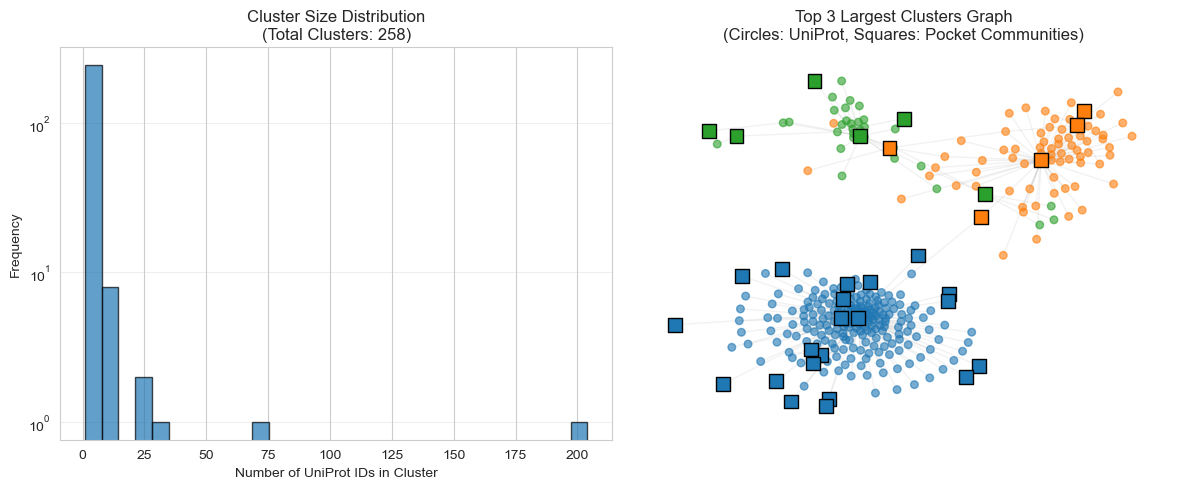

In [ ]:
# Visualization
import matplotlib.pyplot as plt

# 1. Plot Cluster Size Distribution (UniProt nodes only)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sizes = list(cluster_sizes_louvain.values())
plt.hist(sizes, bins=30, edgecolor='black', alpha=0.7)
plt.title(f"Cluster Size Distribution\n(Total Clusters: {len(cluster_sizes_louvain)})")
plt.xlabel("Number of UniProt IDs in Cluster")
plt.ylabel("Frequency")
plt.yscale('log')
plt.grid(axis='y', alpha=0.3)

# 2. Visualize Top Clusters (Subgraph)
plt.subplot(1, 2, 2)

# Identify top 3 largest clusters (by number of UniProt nodes)
top_clusters = cluster_sizes_louvain.most_common(3)
top_cluster_ids = [c[0] for c in top_clusters]
print(f"Visualizing top 3 clusters with IDs: {top_cluster_ids}")

# Collect all nodes (UniProt + Community) belonging to these clusters
subgraph_nodes = set()
node_to_cluster_color = {}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

for i, cluster_id in enumerate(top_cluster_ids):
    # communities_louvain is a list of sets containing all nodes in that community
    nodes_in_cluster = communities_louvain[cluster_id]
    subgraph_nodes.update(nodes_in_cluster)
    
    for node in nodes_in_cluster:
        node_to_cluster_color[node] = colors[i]

# Create subgraph
H = G_nx.subgraph(subgraph_nodes)

# Layout
pos = nx.spring_layout(H, k=0.15, seed=42, iterations=50)

# Separate nodes by type for different shapes
uniprot_nodes = [n for n in H.nodes() if not str(n).startswith('comm_')]
comm_nodes = [n for n in H.nodes() if str(n).startswith('comm_')]

# Draw UniProt nodes (Circles)
nx.draw_networkx_nodes(H, pos, 
                       nodelist=uniprot_nodes, 
                       node_color=[node_to_cluster_color[n] for n in uniprot_nodes],
                       node_shape='o', 
                       node_size=30, 
                       alpha=0.6, 
                       label='UniProt')

# Draw Community nodes (Squares)
nx.draw_networkx_nodes(H, pos, 
                       nodelist=comm_nodes, 
                       node_color=[node_to_cluster_color[n] for n in comm_nodes],
                       node_shape='s', 
                       node_size=100, 
                       edgecolors='black', 
                       alpha=1.0, 
                       label='Pocket Comm')

# Draw edges
nx.draw_networkx_edges(H, pos, alpha=0.1, edge_color='gray')

plt.title("Top 3 Largest Clusters Graph\n(Circles: UniProt, Squares: Pocket Communities)")
plt.axis('off')
plt.tight_layout()
plt.show()

## Option 2: UniProt-UniProt Similarity Graph

Build feature vectors for each UniProt based on pocket community membership, then create a similarity graph.

In [ ]:
# Build feature vectors: f_u[c] = count of PDB chains for UniProt u in community c
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.preprocessing import normalize

# Create community index
community_list = sorted(unique_communities)
community_idx = {c: i for i, c in enumerate(community_list)}
uniprot_list = sorted(unique_uniprots_opt3)
uniprot_idx = {u: i for i, u in enumerate(uniprot_list)}

# Build sparse feature matrix (UniProt x Community)
n_uniprots = len(uniprot_list)
n_communities = len(community_list)

feature_matrix = lil_matrix((n_uniprots, n_communities), dtype=np.float32)

for _, row in edge_weights.iterrows():
    u_idx = uniprot_idx[row['uniprot']]
    c_idx = community_idx[row['community']]
    feature_matrix[u_idx, c_idx] = row['weight']

feature_matrix = feature_matrix.tocsr()
print(f"Feature matrix shape: {feature_matrix.shape}")
print(f"Non-zero entries: {feature_matrix.nnz}")

In [ ]:
# Compute pairwise cosine similarity and build similarity graph
# Normalize rows for cosine similarity
normalized = normalize(feature_matrix, norm='l2', axis=1)

# Compute similarity matrix
sim_matrix = normalized @ normalized.T

# Build edges above threshold
def get_similarity_edges(sim_matrix, threshold):
    """Extract edges from similarity matrix above threshold"""
    sim_coo = sim_matrix.tocoo()
    edges = []
    for i, j, sim in zip(sim_coo.row, sim_coo.col, sim_coo.data):
        if i < j and sim >= threshold:
            edges.append((uniprot_list[i], uniprot_list[j], sim))
    return edges

# Default threshold
similarity_threshold = 0.3
sim_edges = get_similarity_edges(sim_matrix, similarity_threshold)
print(f"Similarity edges (threshold={similarity_threshold}): {len(sim_edges)}")

In [ ]:
# Build networkx graph from similarity edges
G_sim = nx.Graph()
G_sim.add_nodes_from(uniprot_list)

for u, v, sim in sim_edges:
    G_sim.add_edge(u, v, weight=sim)

print(f"Similarity graph: {G_sim.number_of_nodes()} nodes, {G_sim.number_of_edges()} edges")

# Run community detection on similarity graph
if G_sim.number_of_edges() > 0:
    communities_sim = louvain_communities(G_sim, weight='weight', resolution=1.0, seed=42)
    print(f"Louvain on similarity graph found {len(communities_sim)} communities")
    
    # Extract cluster labels
    uniprot_clusters_sim = {}
    for cluster_id, community in enumerate(communities_sim):
        for node in community:
            uniprot_clusters_sim[node] = cluster_id
else:
    # No edges, each node is its own cluster
    uniprot_clusters_sim = {u: i for i, u in enumerate(uniprot_list)}
    print("No edges above threshold, each UniProt is its own cluster")

cluster_sizes_sim = Counter(uniprot_clusters_sim.values())
print(f"Cluster size distribution (top 10): {cluster_sizes_sim.most_common(10)}")

## Compare Clustering Results and Create Final Labels

In [ ]:
# Create a summary DataFrame with clustering results
cluster_results = pd.DataFrame({
    'uniprot': uniprot_list,
    'cluster_bipartite_louvain': [uniprot_clusters_louvain.get(u, -1) for u in uniprot_list],
    'cluster_similarity_louvain': [uniprot_clusters_sim.get(u, -1) for u in uniprot_list]
})

print("Clustering comparison:")
print(f"  Bipartite + Louvain: {cluster_results['cluster_bipartite_louvain'].nunique()} clusters")
print(f"  Similarity + Louvain: {cluster_results['cluster_similarity_louvain'].nunique()} clusters")

cluster_results.head(10)

In [ ]:
# Function to run clustering with different similarity thresholds
def cluster_with_threshold(sim_matrix, uniprot_list, threshold):
    """Run clustering on similarity graph with given threshold"""
    edges = get_similarity_edges(sim_matrix, threshold)
    
    G = nx.Graph()
    G.add_nodes_from(uniprot_list)
    
    for u, v, sim in edges:
        G.add_edge(u, v, weight=sim)
    
    if G.number_of_edges() == 0:
        # No edges, each node is its own cluster
        return {u: i for i, u in enumerate(uniprot_list)}, 0, len(uniprot_list)
    
    communities = louvain_communities(G, weight='weight', resolution=1.0, seed=42)
    
    clusters = {}
    for cluster_id, community in enumerate(communities):
        for node in community:
            clusters[node] = cluster_id
    
    n_clusters = len(set(clusters.values()))
    return clusters, len(edges), n_clusters

# Try different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = {}

for thresh in thresholds:
    clusters, n_edges, n_clusters = cluster_with_threshold(sim_matrix, uniprot_list, thresh)
    threshold_results[thresh] = {
        'clusters': clusters,
        'n_clusters': n_clusters,
        'n_edges': n_edges
    }
    print(f"Threshold {thresh}: {n_edges} edges, {n_clusters} clusters")

In [ ]:
# Add threshold-based clusters to results
for thresh in thresholds:
    col_name = f'cluster_sim_thresh_{thresh}'
    cluster_results[col_name] = [threshold_results[thresh]['clusters'][u] for u in unique_uniprots_opt3]

# Save the clustering results
output_path = "../data/uniprot_cluster_labels.csv"
cluster_results.to_csv(output_path, index=False)
print(f"Saved clustering results to: {output_path}")
print(f"Shape: {cluster_results.shape}")
cluster_results.head()

In [ ]:
# Visualize cluster size distributions
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Bipartite Louvain
ax = axes[0, 0]
sizes = list(Counter(cluster_results['cluster_bipartite_louvain']).values())
ax.hist(sizes, bins=30, edgecolor='black')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')
ax.set_title(f'Bipartite + Louvain ({len(sizes)} clusters)')
ax.set_yscale('log')

# Similarity threshold 0.3
ax = axes[0, 1]
sizes = list(Counter(cluster_results['cluster_sim_thresh_0.3']).values())
ax.hist(sizes, bins=30, edgecolor='black')
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Count')
ax.set_title(f'Similarity (τ=0.3) + Louvain ({len(sizes)} clusters)')
ax.set_yscale('log')

# Number of clusters vs threshold
ax = axes[1, 0]
ax.plot(thresholds, [threshold_results[t]['n_clusters'] for t in thresholds], 'bo-')
ax.set_xlabel('Similarity Threshold')
ax.set_ylabel('Number of Clusters')
ax.set_title('Clusters vs Similarity Threshold')

# Number of edges vs threshold
ax = axes[1, 1]
ax.plot(thresholds, [threshold_results[t]['n_edges'] for t in thresholds], 'ro-')
ax.set_xlabel('Similarity Threshold')
ax.set_ylabel('Number of Edges')
ax.set_title('Edges vs Similarity Threshold')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../data/output/uniprot_clustering_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## Option 3: Bipartite Clustering for Multiple Pocket QCov Thresholds

Run the bipartite graph clustering (UniProt ↔ Pocket Community) for all available thresholds:
- pocket_qcov__50__community
- pocket_qcov__70__community  
- pocket_qcov__95__community
- pocket_qcov__100__community

In [27]:
# Define all pocket qcov thresholds to analyze
pocket_qcov_thresholds = [50, 70, 95, 100]
pocket_community_cols = [f'pocket_qcov__{t}__community' for t in pocket_qcov_thresholds]

# Verify columns exist
for col in pocket_community_cols:
    if col in annot_df.columns:
        n_unique = annot_df[col].nunique()
        print(f"{col}: {n_unique} unique communities")
    else:
        print(f"{col}: NOT FOUND")

pocket_qcov__50__community: 3478 unique communities
pocket_qcov__70__community: 5278 unique communities
pocket_qcov__95__community: 17385 unique communities
pocket_qcov__100__community: 23931 unique communities


In [28]:
def run_bipartite_clustering(filtered_annot, target_uniprots, community_col, threshold_name):
    """
    Run Option 3 bipartite clustering for a given pocket community column.
    
    Returns:
        dict: uniprot -> cluster_id mapping
        dict: statistics about the clustering
    """
    import networkx as nx
    from networkx.algorithms.community import louvain_communities
    from collections import Counter
    
    # Build UniProt to Pocket Community edges
    uniprot_community_edges = []
    for _, row in filtered_annot.iterrows():
        pdb_chain = row['pdb_chain_key']
        community = row[community_col]
        uniprot_str = row['uniprot_ids_str']
        
        if pd.isna(community) or pd.isna(uniprot_str):
            continue
        
        # Parse UniProt IDs
        uniprots = [u.strip() for u in str(uniprot_str).split(',')]
        for uniprot in uniprots:
            if uniprot in target_uniprots:
                uniprot_community_edges.append({
                    'uniprot': uniprot,
                    'community': community,
                    'pdb_chain': pdb_chain
                })
    
    if len(uniprot_community_edges) == 0:
        return {}, {'n_uniprots': 0, 'n_communities': 0, 'n_edges': 0, 'n_clusters': 0}
    
    uniprot_community_df = pd.DataFrame(uniprot_community_edges)
    
    # Aggregate edge weights
    edge_weights = uniprot_community_df.groupby(['uniprot', 'community']).size().reset_index(name='weight')
    
    unique_uniprots = sorted(edge_weights['uniprot'].unique())
    unique_communities = sorted(edge_weights['community'].unique())
    
    # Build networkx bipartite graph
    G_nx = nx.Graph()
    
    # Add UniProt nodes
    for uniprot in unique_uniprots:
        G_nx.add_node(uniprot, bipartite=0, node_type='uniprot')
    
    # Add community nodes
    for community in unique_communities:
        G_nx.add_node(f"comm_{community}", bipartite=1, node_type='community')
    
    # Add weighted edges
    for _, row in edge_weights.iterrows():
        G_nx.add_edge(row['uniprot'], f"comm_{row['community']}", weight=row['weight'])
    
    # Run Louvain community detection
    communities_louvain = louvain_communities(G_nx, weight='weight', resolution=1.0, seed=42)
    
    # Extract cluster labels for UniProt nodes only
    uniprot_clusters = {}
    for cluster_id, community in enumerate(communities_louvain):
        for node in community:
            if not str(node).startswith('comm_'):
                uniprot_clusters[node] = cluster_id
    
    # Statistics
    cluster_sizes = Counter(uniprot_clusters.values())
    stats = {
        'n_uniprots': len(unique_uniprots),
        'n_communities': len(unique_communities),
        'n_edges': G_nx.number_of_edges(),
        'n_clusters': len(cluster_sizes),
        'largest_cluster': max(cluster_sizes.values()) if cluster_sizes else 0,
        'n_singletons': sum(1 for s in cluster_sizes.values() if s == 1)
    }
    
    return uniprot_clusters, stats

print("Function defined successfully")

Function defined successfully


In [29]:
# Run bipartite clustering for all thresholds
bipartite_results = {}

for threshold in pocket_qcov_thresholds:
    col_name = f'pocket_qcov__{threshold}__community'
    print(f"\n{'='*60}")
    print(f"Processing threshold: {threshold}% (column: {col_name})")
    print('='*60)
    
    clusters, stats = run_bipartite_clustering(
        filtered_annot, 
        target_uniprots, 
        col_name, 
        threshold
    )
    
    bipartite_results[threshold] = {
        'clusters': clusters,
        'stats': stats
    }
    
    print(f"  UniProts covered: {stats['n_uniprots']}")
    print(f"  Pocket communities: {stats['n_communities']}")
    print(f"  Graph edges: {stats['n_edges']}")
    print(f"  Resulting clusters: {stats['n_clusters']}")
    print(f"  Largest cluster size: {stats['largest_cluster']}")
    print(f"  Singleton clusters: {stats['n_singletons']}")


Processing threshold: 50% (column: pocket_qcov__50__community)
  UniProts covered: 837
  Pocket communities: 523
  Graph edges: 1176
  Resulting clusters: 258
  Largest cluster size: 204
  Singleton clusters: 170

Processing threshold: 70% (column: pocket_qcov__70__community)
  UniProts covered: 837
  Pocket communities: 523
  Graph edges: 1176
  Resulting clusters: 258
  Largest cluster size: 204
  Singleton clusters: 170

Processing threshold: 70% (column: pocket_qcov__70__community)
  UniProts covered: 837
  Pocket communities: 682
  Graph edges: 1307
  Resulting clusters: 286
  Largest cluster size: 202
  Singleton clusters: 202

Processing threshold: 95% (column: pocket_qcov__95__community)
  UniProts covered: 837
  Pocket communities: 682
  Graph edges: 1307
  Resulting clusters: 286
  Largest cluster size: 202
  Singleton clusters: 202

Processing threshold: 95% (column: pocket_qcov__95__community)
  UniProts covered: 837
  Pocket communities: 2021
  Graph edges: 2552
  Resulti

In [30]:
# Create combined results DataFrame with all thresholds
# Get all UniProt IDs that appear in any threshold
all_uniprots = set()
for threshold in pocket_qcov_thresholds:
    all_uniprots.update(bipartite_results[threshold]['clusters'].keys())

all_uniprots = sorted(all_uniprots)
print(f"Total unique UniProts across all thresholds: {len(all_uniprots)}")

# Build results DataFrame
bipartite_cluster_results = pd.DataFrame({'uniprot': all_uniprots})

for threshold in pocket_qcov_thresholds:
    col_name = f'cluster_bipartite_qcov_{threshold}'
    clusters = bipartite_results[threshold]['clusters']
    # Use -1 for UniProts not in this threshold's clustering
    bipartite_cluster_results[col_name] = [clusters.get(u, -1) for u in all_uniprots]

print(f"\nResults DataFrame shape: {bipartite_cluster_results.shape}")
bipartite_cluster_results.head(10)

Total unique UniProts across all thresholds: 837

Results DataFrame shape: (837, 5)


,uniprot,cluster_bipartite_qcov_50,cluster_bipartite_qcov_70,cluster_bipartite_qcov_95,cluster_bipartite_qcov_100
0,O00141,128,101,143,333
1,O00206,117,130,302,319
2,O00238,128,101,143,333
3,O00255,0,0,212,0
4,O00311,128,101,143,333
5,O00329,72,79,114,115
6,O00408,125,138,200,309
7,O00418,151,171,243,256
8,O00429,220,245,0,1
9,O00444,128,101,143,333


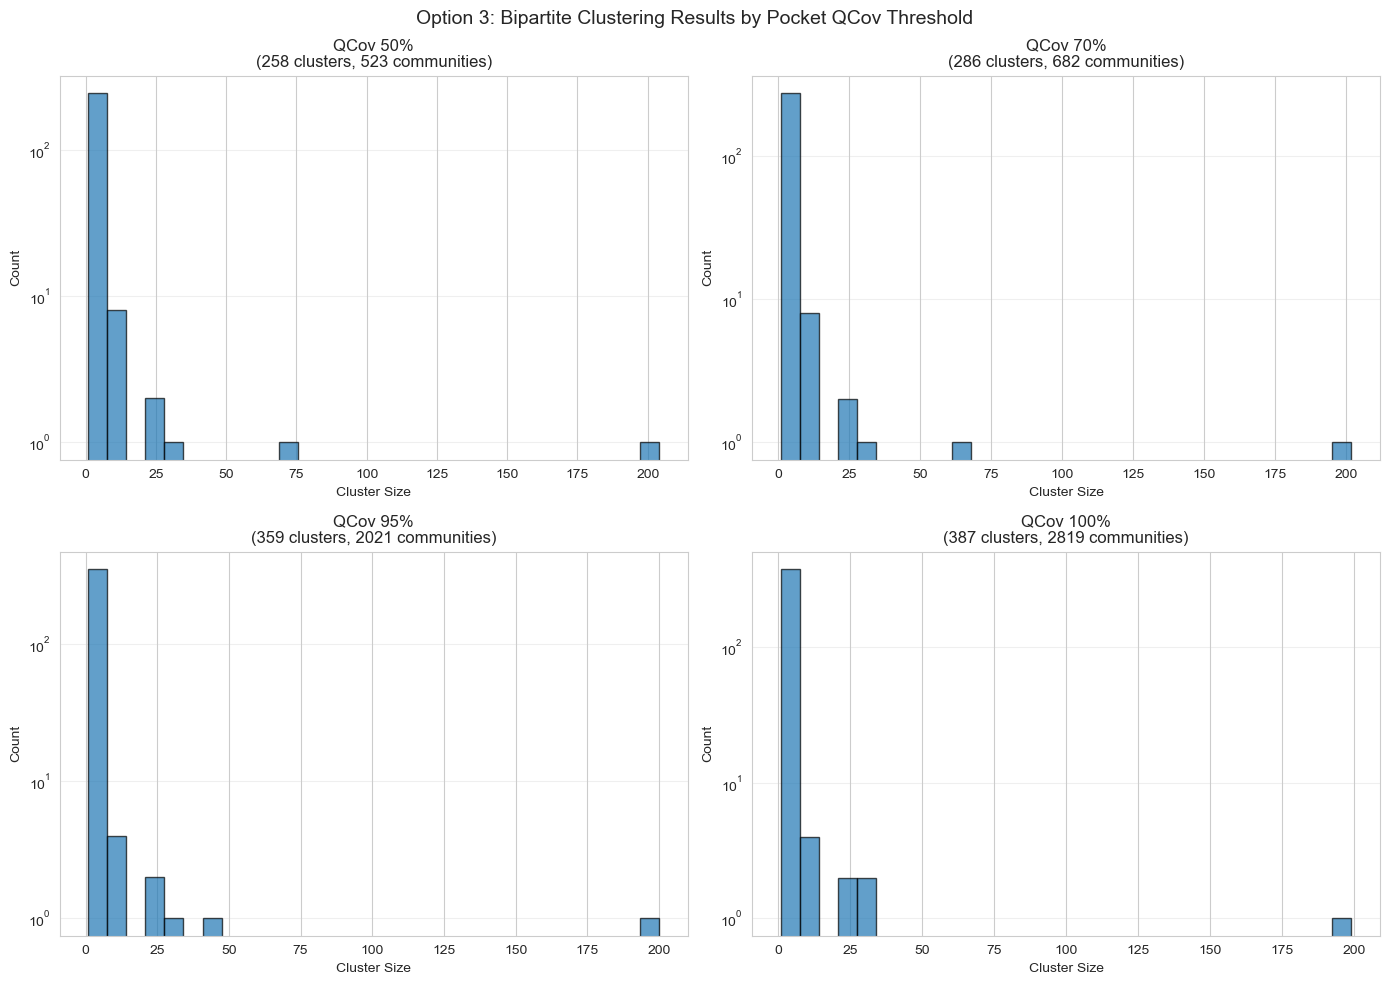

In [31]:
# Visualize clustering results across thresholds
import matplotlib.pyplot as plt
from collections import Counter

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, threshold in enumerate(pocket_qcov_thresholds):
    ax = axes[idx // 2, idx % 2]
    
    col_name = f'cluster_bipartite_qcov_{threshold}'
    # Exclude -1 (unclustered)
    valid_clusters = bipartite_cluster_results[bipartite_cluster_results[col_name] != -1][col_name]
    cluster_sizes = list(Counter(valid_clusters).values())
    
    stats = bipartite_results[threshold]['stats']
    
    ax.hist(cluster_sizes, bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Count')
    ax.set_title(f'QCov {threshold}%\n({stats["n_clusters"]} clusters, {stats["n_communities"]} communities)')
    ax.set_yscale('log')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Option 3: Bipartite Clustering Results by Pocket QCov Threshold', fontsize=14)
plt.tight_layout()
plt.savefig('../data/output/bipartite_clustering_by_qcov.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# Summary statistics table
summary_data = []
for threshold in pocket_qcov_thresholds:
    stats = bipartite_results[threshold]['stats']
    col_name = f'cluster_bipartite_qcov_{threshold}'
    valid_clusters = bipartite_cluster_results[bipartite_cluster_results[col_name] != -1][col_name]
    cluster_sizes = list(Counter(valid_clusters).values())
    
    summary_data.append({
        'QCov Threshold': f'{threshold}%',
        'Pocket Communities': stats['n_communities'],
        'UniProts Covered': stats['n_uniprots'],
        'Graph Edges': stats['n_edges'],
        'Clusters': stats['n_clusters'],
        'Singletons': stats['n_singletons'],
        'Largest Cluster': stats['largest_cluster'],
        'Median Cluster Size': np.median(cluster_sizes) if cluster_sizes else 0,
        'Mean Cluster Size': np.mean(cluster_sizes) if cluster_sizes else 0
    })

summary_df = pd.DataFrame(summary_data)
print("Summary of Bipartite Clustering (Option 3) Results:\n")
summary_df

Summary of Bipartite Clustering (Option 3) Results:



,QCov Threshold,Pocket Communities,UniProts Covered,Graph Edges,Clusters,Singletons,Largest Cluster,Median Cluster Size,Mean Cluster Size
0,50%,523,837,1176,258,170,204,1.0,3.244186
1,70%,682,837,1307,286,202,202,1.0,2.926573
2,95%,2021,837,2552,359,288,200,1.0,2.331476
3,100%,2819,837,3311,387,316,199,1.0,2.162791


In [33]:
# Save the bipartite clustering results
output_path = "../data/uniprot_bipartite_cluster_labels.csv"
bipartite_cluster_results.to_csv(output_path, index=False)
print(f"Saved bipartite clustering results to: {output_path}")
print(f"Shape: {bipartite_cluster_results.shape}")
print(f"\nColumns: {list(bipartite_cluster_results.columns)}")

Saved bipartite clustering results to: ../data/uniprot_bipartite_cluster_labels.csv
Shape: (837, 5)

Columns: ['uniprot', 'cluster_bipartite_qcov_50', 'cluster_bipartite_qcov_70', 'cluster_bipartite_qcov_95', 'cluster_bipartite_qcov_100']
